In [210]:
%matplotlib inline

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import glob
import warnings
warnings.filterwarnings('ignore')

In [212]:
files = glob.glob("data/d*.csv")

df_list = []
for i in files:
    csv = pd.read_csv(i)
    df_list.append(csv)

In [213]:
aic_list = []
coef_list = []
def arma_df(data, n):
    aic = np.zeros((n,n))
    coef = np.zeros((n,n))
    print('yes')
    for i in range(n):
        for j in range(n):
            # Estimation du modèle ARMA(p,q)
            result = ARIMA(data, order=(j,0,i), trend='n').fit()
            # Critère Akaike 
            aic[p][q] = result.aic/data.size
            
            # Siginificativité des paramètres
            if (result.pvalues <= 0.05).all():
                coef[p][q] = 1
            else:
                coef[p][q] = 0

    
    aic = pd.DataFrame(aic)
    coef = pd.DataFrame(coef)
    return aic,coef




In [214]:
print(coef_list)
print(aic_list)

[]
[]


In [215]:
coef_dict = {0: "Paramètres \n non significatifs" , 1 : "Paramètres \n significatifs"}
note=[0,0]
for i in range(2):
    note[p] = coef_list[p].replace(coef_dict)

def heatmap_coef(data,note, color):
    fig, ax = plt.subplots(figsize=(15,7))
    ax = sns.heatmap(data,annot=note,linewidth=.5 ,fmt = '', cmap=color)
    ax.set(xlabel="AR", ylabel="MA")
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=True, rotation=0)
    ax.collections[0].colorbar.ax.invert_yaxis()
    plt.show()

heatmap_coef(aic_list[0],note[0], "Reds")


IndexError: list index out of range

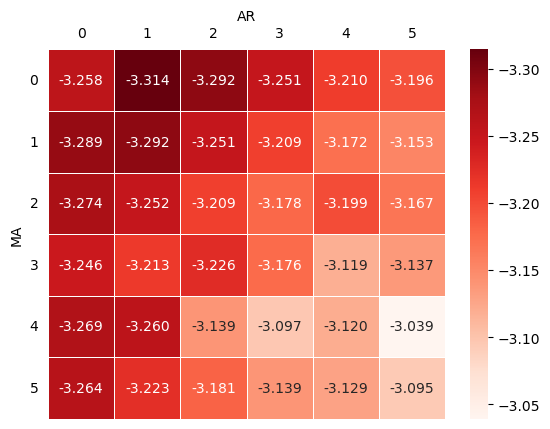

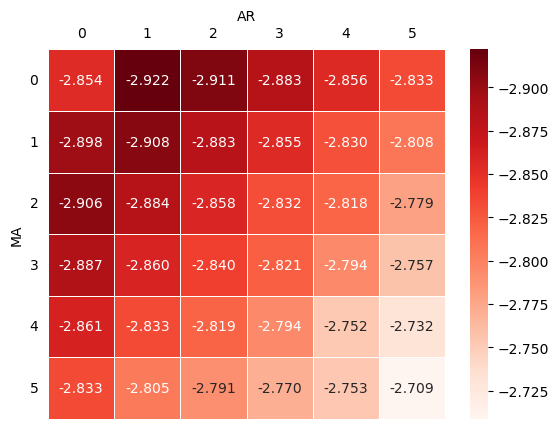

In [ ]:
def heatmap_aic(data, color):
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, annot=True, fmt=".3f",linewidth=.5 , cmap=color)
    ax.set(xlabel="AR", ylabel="MA")
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=True, rotation=0)
    ax.collections[0].colorbar.ax.invert_yaxis()
    plt.show()

for i in range(2): 
    heatmap_aic(aic_list[p], "Reds_r")


In [337]:
def test_df(data, n):
    aic = np.zeros((n,n))
    coef = np.zeros((n,n))
    homo = np.zeros((n,n))
    auto = np.zeros((n,n))
    norm = np.zeros((n,n))

    for q in range(n):
        for p in range(n):
            # Estimation du modèle ARMA(p,q)
            result = ARIMA(data, order=(p,0,q), trend='n').fit()
            # Critère Akaike 
            aic[q][p] = result.aic/data.size
            
            # Siginificativité des paramètres
            if (result.pvalues <= 0.05).all():
                coef[q][p] = 1
            else:
                coef[q][p] = 0

            # Test autocorrélation des résidus (Ljung-Box)
            if (result.test_serial_correlation('ljungbox',lags=20, df_adjust=True)[0][1][p+q:]> 0.05).all():
                auto[q][p] = 1
            else:
                auto[q][p] = 0

            # Homoscédasticité des résidus (ARCH)
            if sm.stats.diagnostic.het_arch(result.resid, nlags=8)[2] > 0.05:
                homo[q][p] = 1
            else:
                homo[q][p] = 0
        
            # Normalité des résidus (JB)
            if result.test_normality('jarquebera')[0][1] > 0.05:
                norm[p][q] = 1
            else:
                norm[q][p] = 0
    
    aic = pd.DataFrame(aic)
    coef = pd.DataFrame(coef)
    homo = pd.DataFrame(homo)
    auto = pd.DataFrame(auto)
    norm = pd.DataFrame(norm)
    return aic,coef,auto,homo,norm

df1,df2,df3,df4,df5 = test_df(df_list[0],6)

In [343]:
dict = {0: "NON" , 1 : "OUI"}
coef = df2.replace(dict)
auto = df3.replace(dict)
homo = df4.replace(dict)
norm = df5.replace(dict)

test=pd.DataFrame(np.zeros((6,6)))
for i in range(6):
    for j in range(6):
        test[i][j] = 'AIC : ' + str(np.round(df1[i][j],3))+ '\n' + 'Significativité : ' + coef[i][j]+ '\n' + 'Abs autocorrélation : ' +auto[i][j] + '\n' + 'Homoscédasticité : ' + homo[i][j]+ '\n' + 'Normalité : ' + norm[i][j]

display(test)

,0,1,2,3,4,5
0,AIC : -3.258\nSignificativité : OUI\nAbs autoc...,AIC : -3.314\nSignificativité : OUI\nAbs autoc...,AIC : -3.292\nSignificativité : NON\nAbs autoc...,AIC : -3.251\nSignificativité : NON\nAbs autoc...,AIC : -3.21\nSignificativité : NON\nAbs autoco...,AIC : -3.196\nSignificativité : NON\nAbs autoc...
1,AIC : -3.289\nSignificativité : NON\nAbs autoc...,AIC : -3.292\nSignificativité : NON\nAbs autoc...,AIC : -3.251\nSignificativité : NON\nAbs autoc...,AIC : -3.209\nSignificativité : NON\nAbs autoc...,AIC : -3.172\nSignificativité : NON\nAbs autoc...,AIC : -3.153\nSignificativité : NON\nAbs autoc...
2,AIC : -3.274\nSignificativité : NON\nAbs autoc...,AIC : -3.252\nSignificativité : NON\nAbs autoc...,AIC : -3.209\nSignificativité : NON\nAbs autoc...,AIC : -3.178\nSignificativité : NON\nAbs autoc...,AIC : -3.199\nSignificativité : NON\nAbs autoc...,AIC : -3.167\nSignificativité : NON\nAbs autoc...
3,AIC : -3.246\nSignificativité : NON\nAbs autoc...,AIC : -3.213\nSignificativité : NON\nAbs autoc...,AIC : -3.226\nSignificativité : NON\nAbs autoc...,AIC : -3.176\nSignificativité : NON\nAbs autoc...,AIC : -3.119\nSignificativité : NON\nAbs autoc...,AIC : -3.137\nSignificativité : NON\nAbs autoc...
4,AIC : -3.269\nSignificativité : NON\nAbs autoc...,AIC : -3.26\nSignificativité : NON\nAbs autoco...,AIC : -3.139\nSignificativité : NON\nAbs autoc...,AIC : -3.097\nSignificativité : NON\nAbs autoc...,AIC : -3.12\nSignificativité : NON\nAbs autoco...,AIC : -3.039\nSignificativité : NON\nAbs autoc...
5,AIC : -3.264\nSignificativité : NON\nAbs autoc...,AIC : -3.223\nSignificativité : NON\nAbs autoc...,AIC : -3.181\nSignificativité : NON\nAbs autoc...,AIC : -3.139\nSignificativité : NON\nAbs autoc...,AIC : -3.129\nSignificativité : NON\nAbs autoc...,AIC : -3.095\nSignificativité : NON\nAbs autoc...


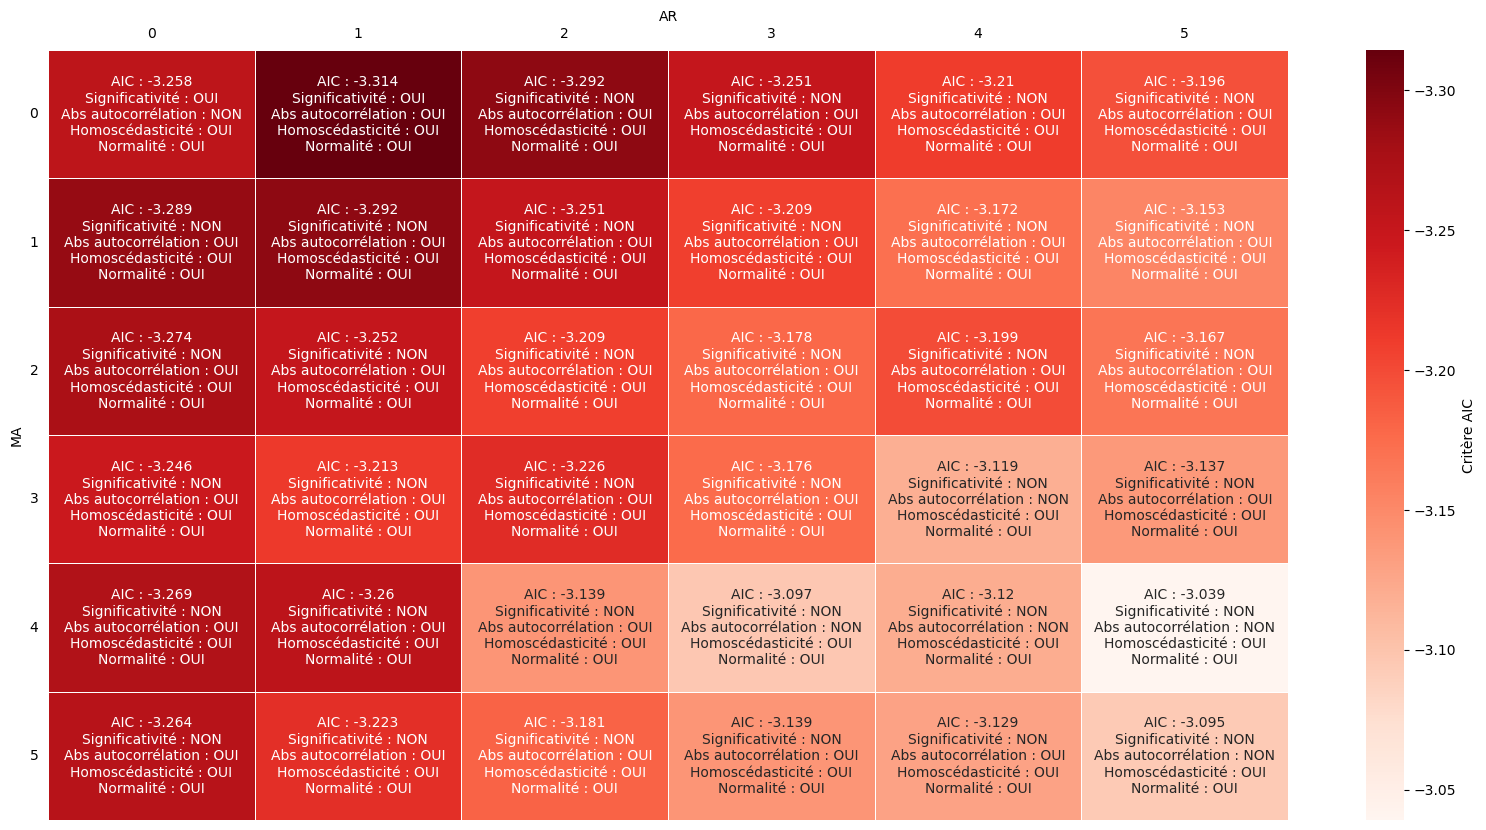

In [345]:

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df1, 
                 annot=test, fmt="",
                 linewidth=.5 , 
                 cmap='Reds_r',
                 cbar_kws={'label': 'Critère AIC'})
ax.set(xlabel="AR", ylabel="MA")
ax.xaxis.set_label_position('top') 
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, left=False, labeltop=True, rotation=0)
ax.collections[0].colorbar.ax.invert_yaxis()
plt.show()


In [353]:
print(ARIMA(df_list[0], order=(1,0,0), trend='n').fit().summary())

                               SARIMAX Results                                
Dep. Variable:               dlble_19   No. Observations:                   47
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  79.888
Date:                Wed, 15 Mar 2023   AIC                           -155.777
Time:                        18:54:44   BIC                           -152.077
Sample:                             0   HQIC                          -154.384
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3218      0.154     -2.084      0.037      -0.624      -0.019
sigma2         0.0020      0.000      5.159      0.000       0.001       0.003
Ljung-Box (L1) (Q):                   0.19   Jarque-